In [603]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import matplotlib
import scipy.integrate
import scipy.optimize
import scipy.stats

def signal_density(x):
    return np.exp(x)/(np.e - 1)

def background_density_np(nu):
    return lambda x: nu * np.exp(-nu * x)/(1 - np.exp(-nu))
    
def background_cdf(nu):
    return lambda x: (1 - np.exp(-nu * x))/(1 - np.exp(-nu))

def tpr(x):
    return (np.e - np.exp(x))/(np.e - 1)

def fpr(x, nu):
    return (np.exp(-nu * x) - np.exp(-nu))/(1 - np.exp(-nu))

def roc_tpr(fpr, nu):
    return (np.e - (np.exp(-nu) + (1 - np.exp(-nu)) * fpr)**(-1/nu))/(np.e - 1)

def signal_posterior(x, nu_prior, nu_lb, nu_ub):
    
    def integrand(nu):
        return signal_density(x)/(signal_density(x) + background_density_np(nu)(x)) * nu_prior(nu)
    
    return scipy.integrate.quad(integrand, nu_lb, nu_ub, limit=100)[0]

def inverse_signal_posterior(q, q_min, q_max, nu_prior, nu_lb, nu_ub):
    
    if q > q_max:
        return 1
    
    if q < q_min:
        return 0
    
    return scipy.optimize.root_scalar(
        lambda x: signal_posterior(x, nu_prior, nu_lb, nu_ub) - q,
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root
    
def marginal_background(x, nu_prior, nu_lb, nu_ub):
    return scipy.integrate.quad(lambda nu: background_density_np(nu)(x) * nu_prior(nu), nu_lb, nu_ub)[0]
    
def nu_posterior(nu, nu_prior, x, marginal_background_val, p_y_one):
    return p_y_one * nu_prior(nu) + (1 - p_y_one) * background_density_np(nu)(x) * nu_prior(nu) / marginal_background_val

def nu_posterior_mean(x, nu_prior, nu_lb, nu_ub, p_y_one):
    marginal_background_val = marginal_background(x, nu_prior, nu_lb, nu_ub)
    return scipy.integrate.quad(
        lambda nu: nu * nu_posterior(nu, nu_prior, x, marginal_background_val, p_y_one),
        nu_lb,
        nu_ub
    )[0]

# Area to the right of the cutoff
def marginal_fpr(x_star, nu_prior, nu_lb, nu_ub):
    def integrand(nu):
        return background_cdf(nu)(x_star) * nu_prior(nu)
    
    return 1 - scipy.integrate.quad(integrand, nu_lb, nu_ub, limit=100)[0]

p_y_one = 0.5
nu_lb = 1
nu_ub = 10
normal_prior_unconstrained = scipy.stats.norm(loc=4, scale=0.1)
normal_prior_scaling = normal_prior_unconstrained.cdf(nu_ub) - normal_prior_unconstrained.cdf(nu_lb)

def normal_prior(nu):
    return normal_prior_unconstrained.pdf(nu)/normal_prior_scaling

def uniform_prior(nu):
    return 1/(nu_ub - nu_lb)

method_names = ["common", "bad", "nuhat", "cal", "calnacs1", "calnacs2"]
prior_names = ["oldp", "newp"]
metrics = ["coverage", "power", "precision", "recall"]

results_dict = dict()
for approach in method_names:
    for prior in prior_names:
        for null in ["marg", "signalnull", "bgnull"]:
            for metric in metrics:
                results_dict[f"{approach}_{prior}_{null}_{metric}"] = list()
                
def nu_conditional_converage(nu, sig_null_x_star, bg_null_x_star, class_con="marg"):
    if class_con == "marg":
        return p_y_one * scipy.integrate.quad(signal_density, sig_null_x_star, 1)[0] + (1-p_y_one) * scipy.integrate.quad(background_density_np(nu), 0, bg_null_x_star)[0]
    elif class_con == "bgnull":
        return scipy.integrate.quad(background_density_np(nu), 0, bg_null_x_star)[0]
    elif class_con == "signalnull":
        return scipy.integrate.quad(signal_density, sig_null_x_star, 1)[0]
    else:
        raise ValueError(class_con)

def nu_conditional_power(nu, sig_null_x_star, bg_null_x_star, class_con="marg"):
    return p_y_one * scipy.integrate.quad(signal_density, bg_null_x_star, 1)[0] + (1-p_y_one) * scipy.integrate.quad(background_density_np(nu), 0, sig_null_x_star)[0]


# Plot parameters

pos_naps_col = "limegreen"
zero_naps_col = "cornflowerblue"

font = {
    'family': 'sans serif',
    'size' : 18,
}

matplotlib.rc('font', **font)
matplotlib.rc('lines', **{'linewidth': 3})

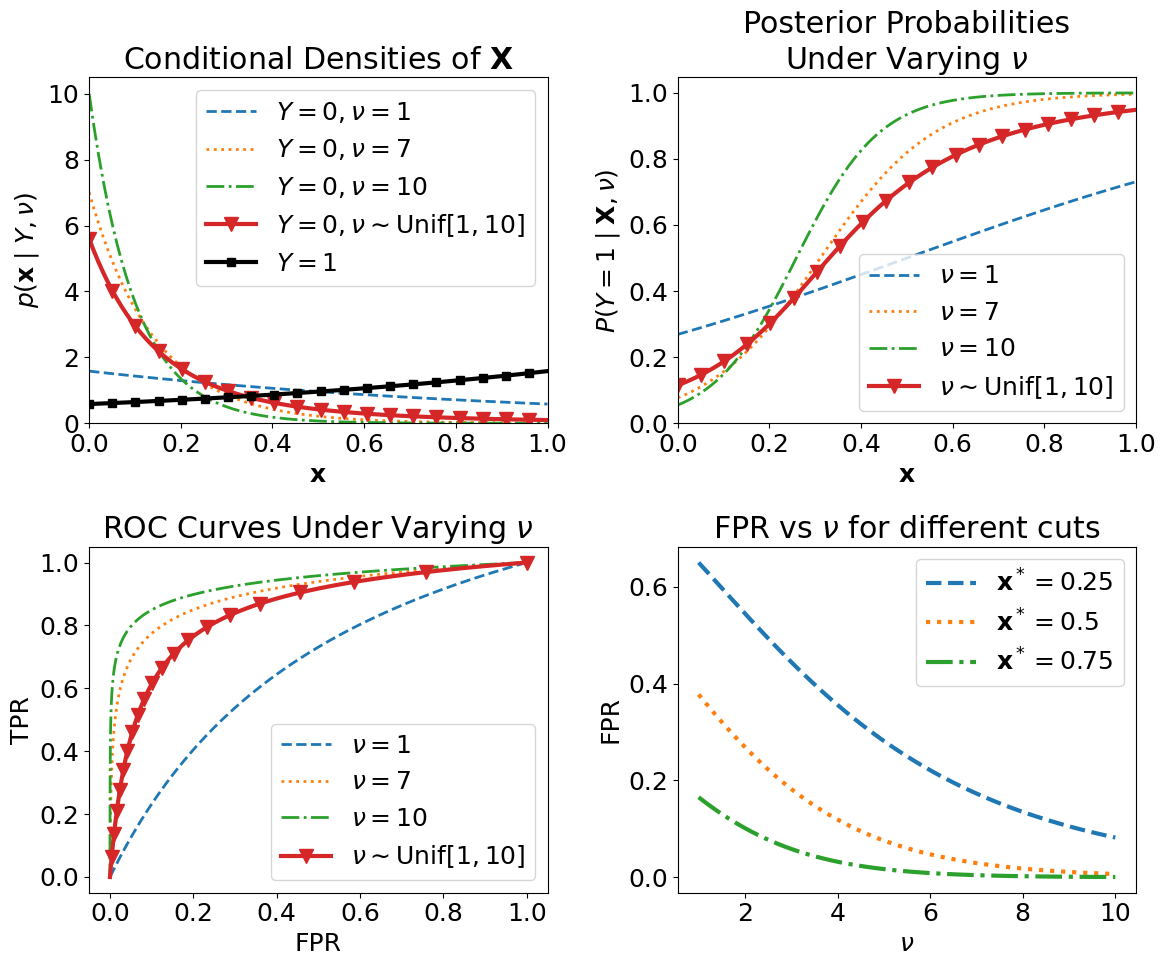

In [585]:
plot_x = np.linspace(0, 1, 100)
x_star = 0.8

linestyles = ["dashed", "dotted", "dashdot"]

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for nu, linestyle in zip([1, 7, 10], linestyles):
    ax[0][0].plot(plot_x, background_density_np(nu)(plot_x), label=r"$Y = 0, \nu=" + str(nu) + r"$", linestyle=linestyle, linewidth=2)
    ax[0][1].plot(plot_x, signal_density(plot_x)/(signal_density(plot_x) + background_density_np(nu)(plot_x)), label=r"$\nu=" + str(nu) + r"$", linestyle=linestyle, linewidth=2)
    
    roc_fpr = fpr(plot_x, nu)
    ax[1][0].plot(roc_fpr, roc_tpr(roc_fpr, nu), label=r"$\nu=" + str(nu) + r"$", linestyle=linestyle, linewidth=2)

ax[0][0].plot(plot_x, [scipy.integrate.quad(lambda a: background_density_np(a)(x) * 1/9, 1, 10)[0] for x in plot_x], label=r"$Y = 0, \nu \sim \text{Unif}[1, 10]$", marker="v", markevery=5, markersize=10)
ax[0][0].plot(plot_x, signal_density(plot_x), label=r"$Y = 1$", color="black", marker="s", markevery=5)
ax[0][1].plot(plot_x, [signal_posterior(x, lambda alpha: 1/9, 1, 10) for x in plot_x], label=r"$\nu \sim \text{Unif}[1, 10]$", marker="v", markevery=5, markersize=10)
ax[1][0].plot([marginal_fpr(x, lambda a: 1/9, 1, 10) for x in plot_x], [scipy.integrate.quad(signal_density, x, 1)[0] for x in plot_x], label=r"$\nu \sim \text{Unif}[1, 10]$", marker="v", markevery=5, markersize=10)

ax[0][0].set_xlim(0, 1)
ax[0][0].set_ylim(0)
ax[0][0].set_xlabel(r"$\mathbf{x}$")
ax[0][0].set_ylabel(r"$p(\mathbf{x} \mid Y, \nu)$")
ax[0][0].legend()
ax[0][0].set_title(r"Conditional Densities of $\mathbf{X}$")

ax[0][1].set_xlabel(r"$\mathbf{x}$")
ax[0][1].set_ylabel(r"$P(Y=1 \mid \mathbf{X}, \nu)$")
ax[0][1].legend()
ax[0][1].set_title("Posterior Probabilities\nUnder Varying " r"$\nu$")
ax[0][1].set_xlim(0, 1)
ax[0][1].set_ylim(0)

ax[1][0].set_title("ROC Curves Under Varying " r"$\nu$")
ax[1][0].set_xlabel("FPR")
ax[1][0].set_ylabel("TPR")
ax[1][0].legend()

plot_nu = np.linspace(1, 10, 100)
for x_star, linestyle in zip([0.25, 0.5, 0.75], linestyles):
    ax[1][1].plot(plot_nu, fpr(x_star, plot_nu), linestyle=linestyle, label=r"$\mathbf{x}^*=$" + str(x_star))

ax[1][1].legend()
ax[1][1].set_title("FPR vs " r"$\nu$" " for different cuts")
ax[1][1].set_xlabel(r"$\nu$")
ax[1][1].set_ylabel("FPR")
fig.tight_layout()
fig.savefig("icml_synth_probs.pdf")

In [ ]:
alphas = np.linspace(0.05, 0.5, 20)
alphas = np.insert(alphas, 0, 0.01)
gamma_prop = 0.01
                
max_signal_posterior = signal_posterior(1, uniform_prior, nu_lb, nu_ub)
min_signal_posterior = signal_posterior(0, uniform_prior, nu_lb, nu_ub)
max_cut = min(max_signal_posterior, 1 - min_signal_posterior)

def miss_rate(q_cut):

    x_signal = inverse_signal_posterior(q_cut, min_signal_posterior, max_signal_posterior, uniform_prior, nu_lb, nu_ub)
    x_bg = inverse_signal_posterior(1 - q_cut, min_signal_posterior, max_signal_posterior, uniform_prior, nu_lb, nu_ub)
    
    return p_y_one * scipy.integrate.quad(signal_density, 0, x_signal)[0] + (1-p_y_one) * marginal_fpr(x_bg, uniform_prior, nu_lb, nu_ub)

common_cutoffs = list()
bad_cutoffs = list()
cal_cutoffs = list()
nuhat_cutoffs = list()
bayes_cutoff = inverse_signal_posterior(0.5, min_signal_posterior, max_signal_posterior, uniform_prior, nu_lb, nu_ub)

for alpha in alphas:

    common_q_cut = scipy.optimize.root_scalar(
        lambda cut: miss_rate(cut) - alpha,
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root
    
    common_bg_null_xstar = inverse_signal_posterior(1 - common_q_cut, min_signal_posterior, max_signal_posterior, uniform_prior, nu_lb, nu_ub)
    common_sig_null_xstar = inverse_signal_posterior(common_q_cut, min_signal_posterior, max_signal_posterior, uniform_prior, nu_lb, nu_ub)
    common_cutoffs.append((common_sig_null_xstar, common_bg_null_xstar))
    
    # Cutoffs
    marg_bg_null_x_star = scipy.optimize.root_scalar(
        lambda x_star: marginal_fpr(x_star, uniform_prior, nu_lb, nu_ub) - alpha, 
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root

    sig_null_x_star = scipy.optimize.root_scalar(
        lambda x_star: scipy.integrate.quad(signal_density, 0, x_star)[0] - alpha, 
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root

    cal_bg_null_xstar = scipy.optimize.root_scalar(
        lambda x_star: scipy.integrate.quad(background_density_np(nu_lb), x_star, 1, limit=100)[0] - alpha, 
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root
    
    def nuhat_bgnull_cut(x):
        nu_hat = nu_posterior_mean(x, uniform_prior, nu_lb, nu_ub, p_y_one)
        return scipy.optimize.root_scalar(
            lambda x: background_cdf(nu_hat)(x) - (1 - alpha),
            x0=0.5,
            bracket=[0, 1],
            method="brentq"
        ).root
    
    nuhat_bg_null_x_star = scipy.optimize.root_scalar(
        lambda x: nuhat_bgnull_cut(x) - x,
        x0=0.5,
        bracket=[0, 1],
        method="brentq"
    ).root
    
    bad_cutoffs.append((sig_null_x_star, marg_bg_null_x_star))
    cal_cutoffs.append((sig_null_x_star, cal_bg_null_xstar))
    nuhat_cutoffs.append((sig_null_x_star, nuhat_bg_null_x_star))
    
    for prior, prior_name in zip([uniform_prior, normal_prior], prior_names):
        
        if prior_name == "oldp":
            cal_p1_bergerhalf_alpha_lb = (alpha/2) * (nu_ub - nu_lb) + nu_lb
        else:
            cal_p1_bergerhalf_alpha_lb = max(nu_lb, normal_prior_unconstrained.ppf(alpha/2 * normal_prior_scaling))
            
        cal_p1_bergerhalf_bg_null_xstar = scipy.optimize.root_scalar(
            lambda x_star: scipy.integrate.quad(background_density_np(cal_p1_bergerhalf_alpha_lb), x_star, 1, limit=100)[0] - alpha/2, 
            x0=0.5, 
            bracket=[0, 1],
            method="brentq"
        ).root
        
        if prior_name == "oldp":
            cal_p1_bergercustom_alpha_lb = (alpha * gamma_prop) * (nu_ub - nu_lb) + nu_lb
        else:
            cal_p1_bergercustom_alpha_lb = max(nu_lb, normal_prior_unconstrained.ppf(alpha * gamma_prop * normal_prior_scaling))
        
        cal_p1_bergercustom_bg_null_xstar = scipy.optimize.root_scalar(
            lambda x_star: scipy.integrate.quad(background_density_np(cal_p1_bergercustom_alpha_lb), x_star, 1, limit=100)[0] - alpha * (1 - gamma_prop), 
            x0=0.5, 
            bracket=[0, 1],
            method="brentq"
        ).root
        
        
        # background null
        def bgnull_power_func(bg_null_xstar):
            return scipy.integrate.quad(signal_density, bg_null_xstar, 1)[0]
        
        results_dict[f"common_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(common_bg_null_xstar, prior, nu_lb, nu_ub))
        results_dict[f"bad_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(marg_bg_null_x_star, prior, nu_lb, nu_ub))
        results_dict[f"nuhat_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(nuhat_bg_null_x_star, prior, nu_lb, nu_ub))
        results_dict[f"cal_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(cal_bg_null_xstar, prior, nu_lb, nu_ub))
        results_dict[f"calnacs1_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(cal_p1_bergerhalf_bg_null_xstar, prior, nu_lb, nu_ub))
        results_dict[f"calnacs2_{prior_name}_bgnull_coverage"].append(1 - marginal_fpr(cal_p1_bergercustom_bg_null_xstar, prior, nu_lb, nu_ub))
        
        results_dict[f"common_{prior_name}_bgnull_power"].append(bgnull_power_func(common_bg_null_xstar))
        results_dict[f"bad_{prior_name}_bgnull_power"].append(bgnull_power_func(marg_bg_null_x_star))
        results_dict[f"nuhat_{prior_name}_bgnull_power"].append(bgnull_power_func(nuhat_bg_null_x_star))
        results_dict[f"cal_{prior_name}_bgnull_power"].append(bgnull_power_func(cal_bg_null_xstar))
        results_dict[f"calnacs1_{prior_name}_bgnull_power"].append(bgnull_power_func(cal_p1_bergerhalf_bg_null_xstar))
        results_dict[f"calnacs2_{prior_name}_bgnull_power"].append(bgnull_power_func(cal_p1_bergercustom_bg_null_xstar))
        
        def bgnull_precision(bg_null_xstar):
            return p_y_one * bgnull_power_func(bg_null_xstar)/((1-p_y_one) * marginal_fpr(bg_null_xstar, prior, nu_lb, nu_ub) + p_y_one * bgnull_power_func(bg_null_xstar))
        
        results_dict[f"common_{prior_name}_bgnull_precision"].append(bgnull_precision(common_bg_null_xstar))
        results_dict[f"bad_{prior_name}_bgnull_precision"].append(bgnull_precision(marg_bg_null_x_star))
        results_dict[f"cal_{prior_name}_bgnull_precision"].append(bgnull_precision(cal_bg_null_xstar))
        results_dict[f"calnacs1_{prior_name}_bgnull_precision"].append(bgnull_precision(cal_p1_bergerhalf_bg_null_xstar))
        results_dict[f"calnacs2_{prior_name}_bgnull_precision"].append(bgnull_precision(cal_p1_bergercustom_bg_null_xstar))
        
        

        # signal null
        signalnull_power = 1 - marginal_fpr(sig_null_x_star, prior, nu_lb, nu_ub)
        
        results_dict[f"common_{prior_name}_signalnull_coverage"].append(scipy.integrate.quad(signal_density, common_sig_null_xstar, 1)[0])
        results_dict[f"bad_{prior_name}_signalnull_coverage"].append(1 - alpha)
        results_dict[f"nuhat_{prior_name}_signalnull_coverage"].append(1 - alpha)
        results_dict[f"cal_{prior_name}_signalnull_coverage"].append(1 - alpha)
        results_dict[f"calnacs1_{prior_name}_signalnull_coverage"].append(1 - alpha)
        results_dict[f"calnacs2_{prior_name}_signalnull_coverage"].append(1 - alpha)
        
        results_dict[f"common_{prior_name}_signalnull_power"].append(1 - marginal_fpr(common_sig_null_xstar, prior, nu_lb, nu_ub))
        results_dict[f"bad_{prior_name}_signalnull_power"].append(signalnull_power)
        results_dict[f"nuhat_{prior_name}_signalnull_power"].append(signalnull_power)
        results_dict[f"cal_{prior_name}_signalnull_power"].append(signalnull_power)
        results_dict[f"calnacs1_{prior_name}_signalnull_power"].append(signalnull_power)
        results_dict[f"calnacs2_{prior_name}_signalnull_power"].append(signalnull_power)
        
        def signalnull_precision(bg_null_xstar):
            return (1-p_y_one) * signalnull_power/(p_y_one * alpha + (1-p_y_one) * signalnull_power)
        
        results_dict[f"common_{prior_name}_signalnull_precision"].append(signalnull_precision(common_bg_null_xstar))
        results_dict[f"bad_{prior_name}_signalnull_precision"].append(signalnull_precision(marg_bg_null_x_star))
        results_dict[f"cal_{prior_name}_signalnull_precision"].append(signalnull_precision(cal_bg_null_xstar))
        results_dict[f"calnacs1_{prior_name}_signalnull_precision"].append(signalnull_precision(cal_p1_bergerhalf_bg_null_xstar))
        results_dict[f"calnacs2_{prior_name}_signalnull_precision"].append(signalnull_precision(cal_p1_bergercustom_bg_null_xstar))
        
        # marginal
        for approach in method_names:
            results_dict[f"{approach}_{prior_name}_marg_coverage"].append(p_y_one * results_dict[f"{approach}_{prior_name}_signalnull_coverage"][-1] + (1-p_y_one) * results_dict[f"{approach}_{prior_name}_bgnull_coverage"][-1])
            results_dict[f"{approach}_{prior_name}_marg_power"].append(p_y_one * results_dict[f"{approach}_{prior_name}_bgnull_power"][-1] + (1-p_y_one) * results_dict[f"{approach}_{prior_name}_signalnull_power"][-1])
        
    
        print(f"{common_bg_null_xstar:0.4f} {marg_bg_null_x_star:0.4f} {cal_bg_null_xstar:0.4f} {cal_p1_bergerhalf_bg_null_xstar:0.4f} {cal_p1_bergercustom_bg_null_xstar:0.4f}")

for key in results_dict:
    results_dict[key] = np.array(results_dict[key])


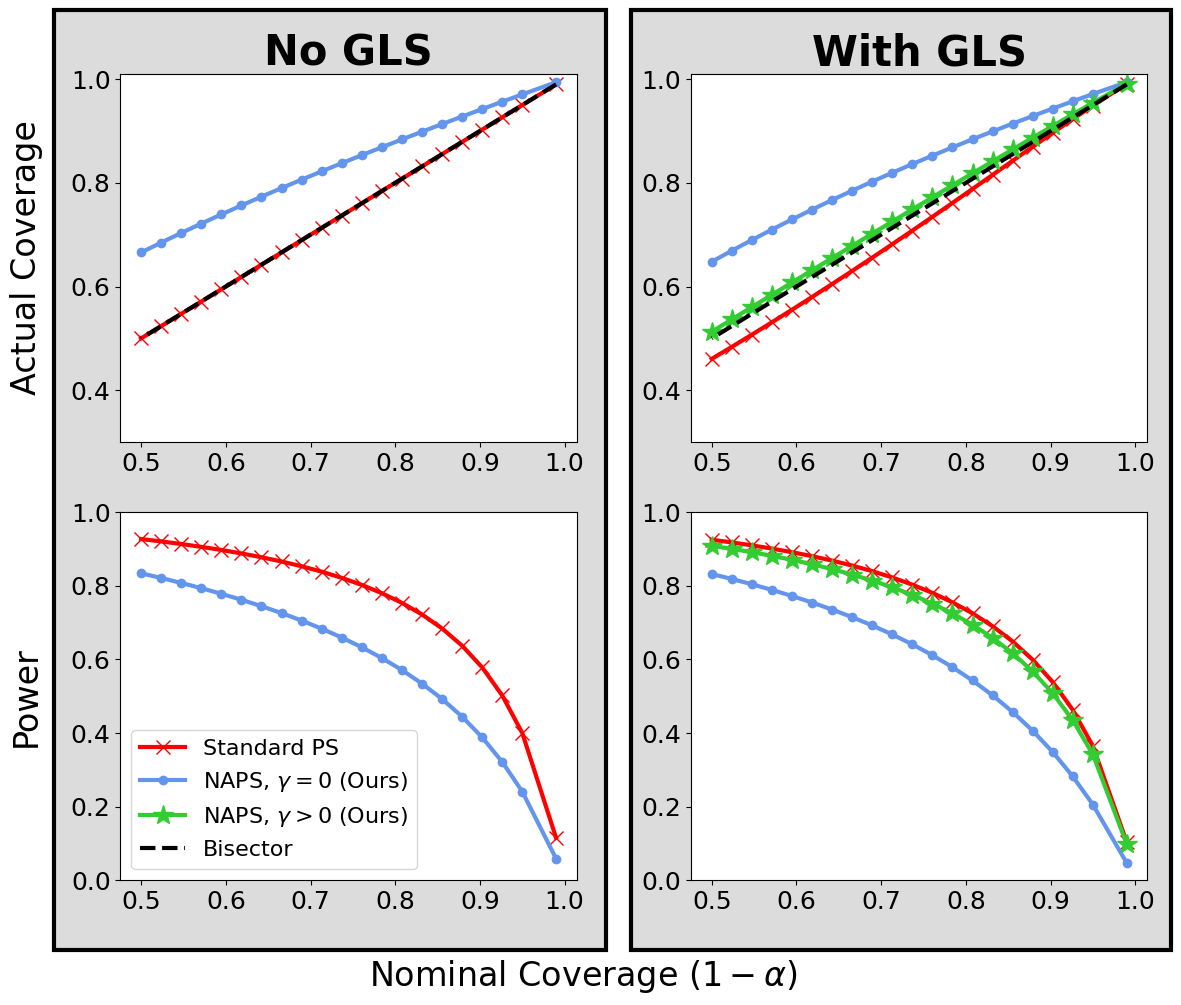

In [605]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

y_upper = 1.01
y_lower = 0.3
y_lower2 = 0
labelpad = 20
axis_label_size = 24
class_con = "marg"

ax[0][0].plot(1-alphas, results_dict[f"common_oldp_{class_con}_coverage"], color="red", marker="x", markersize=10) #, label="Marginal Set-Clf",)
ax[0][0].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_coverage"], color=zero_naps_col, marker="o")#, label=r"NAPS, $\gamma = 0$ (Ours)")
ax[0][0].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black", label="Bisector")
ax[0][0].set_title("No GLS", weight="bold", fontsize=30)
ax[0][0].set_ylabel("Actual Coverage", labelpad=labelpad, fontsize=axis_label_size)
ax[0][0].set_ylim(y_lower, y_upper)

ax[0][1].plot(1-alphas, results_dict[f"common_newp_{class_con}_coverage"], label=r"Standard PS", color="red", marker="x", markersize=10)
ax[0][1].plot(1-alphas, results_dict[f"cal_newp_{class_con}_coverage"], label=r"NAPS $\gamma = 0$ (Ours)", color=zero_naps_col, marker="o")
ax[0][1].plot(1-alphas, results_dict[f"calnacs2_newp_{class_con}_coverage"], label=r"NAPS $\gamma > 0$ (Ours)", color=pos_naps_col, marker="*", markersize=15)
ax[0][1].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black", label="Bisector")
ax[0][1].set_title(f"With GLS", weight="bold", fontsize=30)
ax[0][1].set_ylim(y_lower, y_upper)
    
ax[1][0].plot(1-alphas, results_dict[f"bad_oldp_{class_con}_power"], label="Standard PS", color="red", marker="x", markersize=10)
ax[1][0].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_power"], label=r"NAPS, $\gamma = 0$ (Ours)", color=zero_naps_col, marker="o")
ax[1][0].plot(0.75, -8, label=r"NAPS, $\gamma > 0$ (Ours)", color=pos_naps_col, marker="*", markersize=15)
ax[1][0].plot(0.75, -5, linestyle="dashed", color="black", label="Bisector")
ax[1][0].legend(fontsize=16)
ax[1][0].set_ylabel("Power", labelpad=labelpad, fontsize=axis_label_size)
ax[1][0].set_ylim(y_lower2, 1)

ax[1][1].plot(1-alphas, results_dict[f"bad_newp_{class_con}_power"], label="Marginal Set-Clf", color="red", marker="x", markersize=10)
ax[1][1].plot(0.75, -8, label=r"Marginal Set-Clf, $\nu = 1$", color="red", linestyle="dashed", markersize=10)
ax[1][1].plot(0.75, -8, label=r"Marginal Set-Clf, $\nu = 7$", color="red", linestyle="dotted", markersize=10)
ax[1][1].plot(1-alphas, results_dict[f"cal_newp_{class_con}_power"], label=r"NAPS, $\gamma = 0$ (Ours)", color=zero_naps_col, marker="o")
ax[1][1].plot(1-alphas, results_dict[f"calnacs2_newp_{class_con}_power"], label=r"NAPS, $\gamma > 0$ (Ours)", color=pos_naps_col, marker="*", markersize=15)
ax[1][1].set_ylim(y_lower2, 1)

fig.patches.append(patches.Rectangle((0.059, 0.055), 0.46, 0.94, transform=fig.transFigure, edgecolor='black', linewidth=3, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.540, 0.055), 0.45, 0.94, transform=fig.transFigure, edgecolor='black', linewidth=3, facecolor="gainsboro", zorder=-1))
fig.supxlabel("Nominal Coverage " r"($1-\alpha$)", fontsize=axis_label_size)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

fig.savefig("icml_synth_coverage_power_final.pdf")

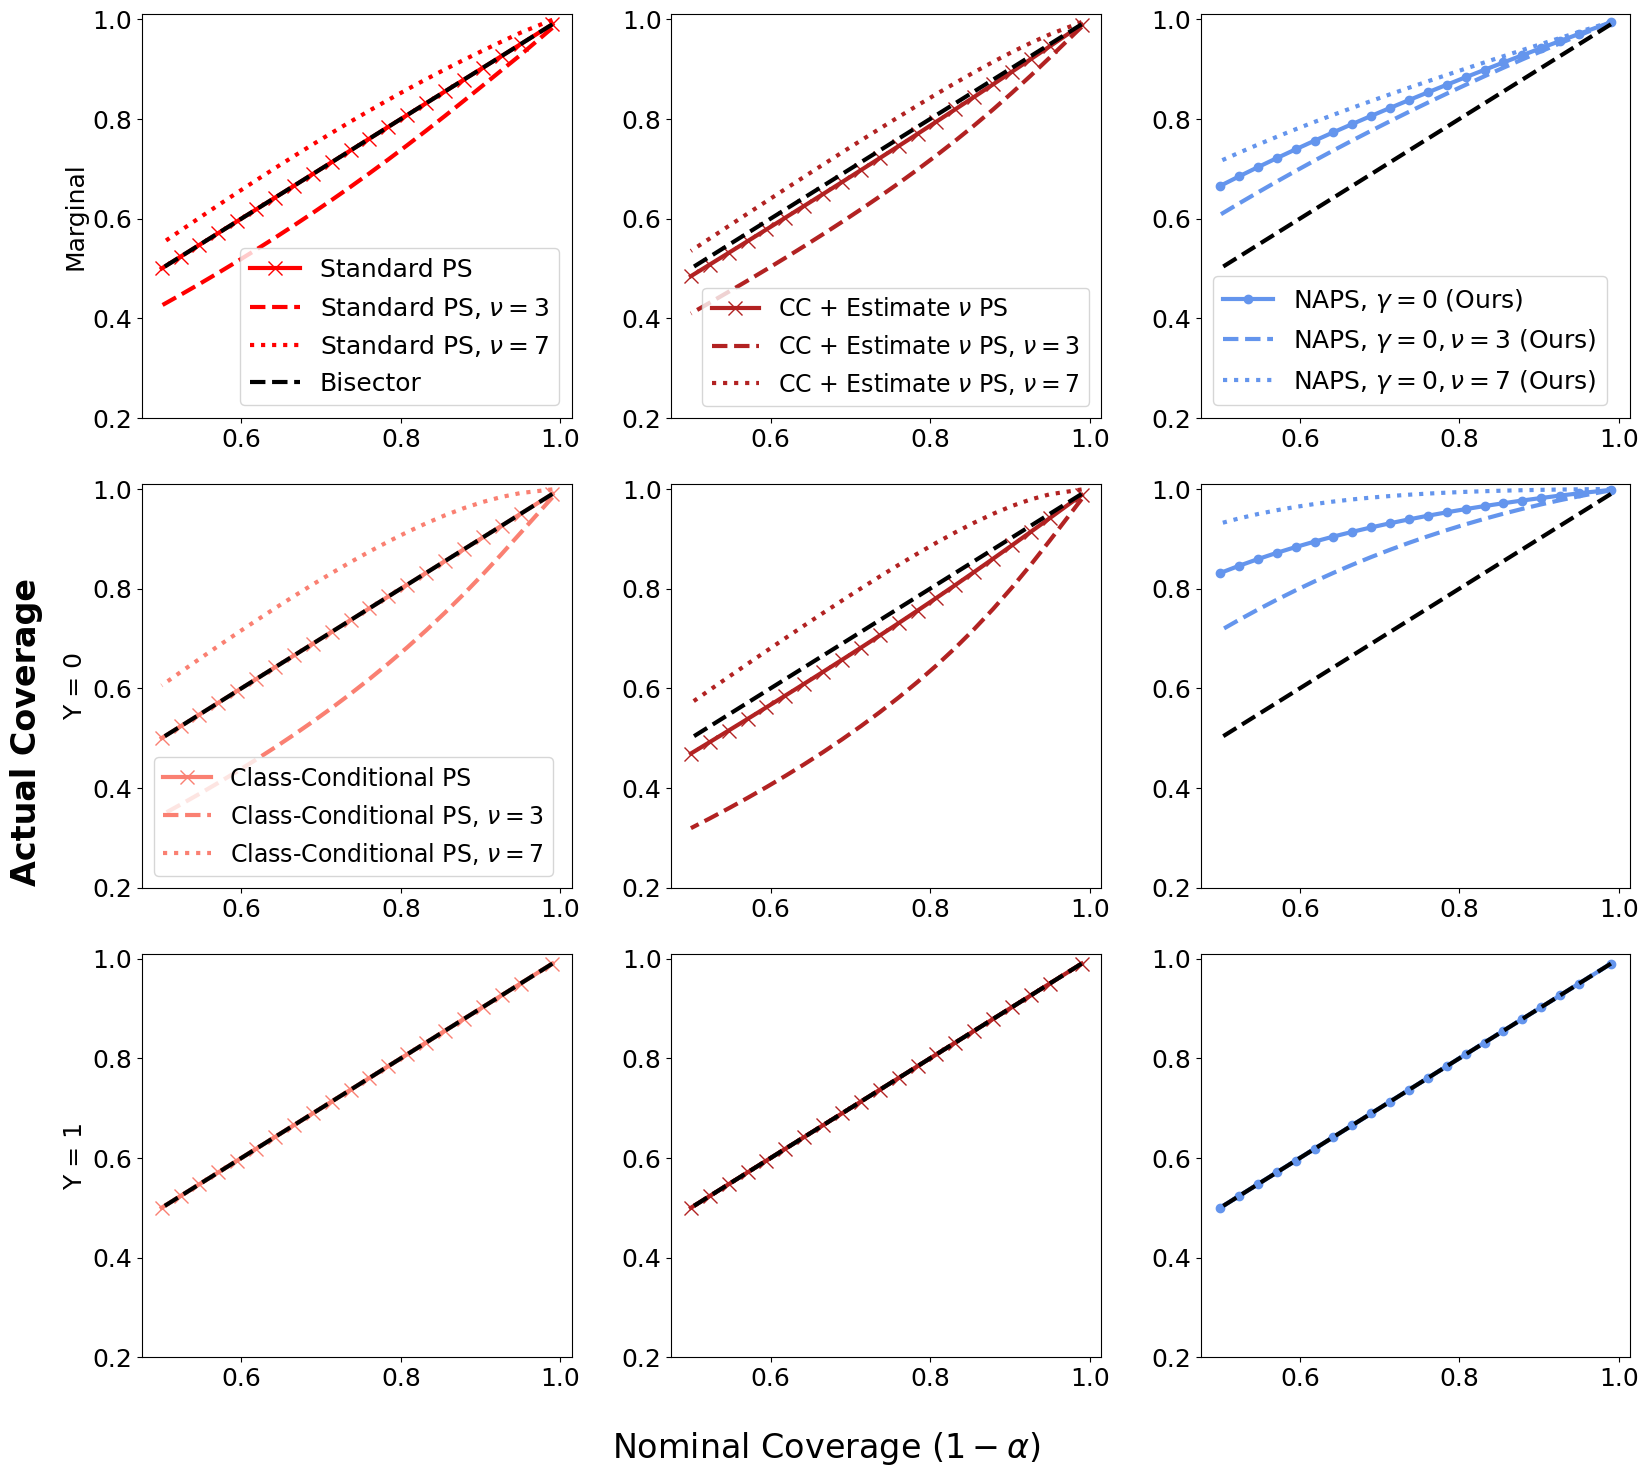

In [606]:
fig, ax = plt.subplots(3, 3, figsize=(17, 15))

y_upper = 1.01
y_lower = 0.2
labelpad = 20
axis_label_size = 24
low_nu = 3
high_nu = 7

pos_naps_col = "limegreen"
zero_naps_col = "cornflowerblue"

for i, stuff in enumerate(zip(["marg", "bgnull", "signalnull"], ["Marginal", "Y = 0", "Y = 1"])):
    class_con, row_label = stuff
    if i == 0:
        ax[i][0].plot(1-alphas, results_dict[f"common_oldp_{class_con}_coverage"], color="red", marker="x", markersize=10, label="Standard PS",)
        ax[i][0].plot(1-alphas, [nu_conditional_converage(low_nu, x[0], x[1], class_con) for x in common_cutoffs], color="red", linestyle="dashed", markersize=10, label=r"Standard PS, $\nu = " + str(low_nu) + "$")
        ax[i][0].plot(1-alphas, [nu_conditional_converage(high_nu, x[0], x[1], class_con) for x in common_cutoffs], color="red", linestyle="dotted", markersize=10, label=r"Standard PS, $\nu = " + str(high_nu) + "$")
    else:
        ax[i][0].plot(1-alphas, results_dict[f"bad_oldp_{class_con}_coverage"], color="salmon", marker="x", markersize=10, label="Class-Conditional PS",)
        ax[i][0].plot(1-alphas, [nu_conditional_converage(low_nu, x[0], x[1], class_con) for x in bad_cutoffs], color="salmon", linestyle="dashed", markersize=10, label=r"Class-Conditional PS, $\nu = " + str(low_nu) + "$")
        ax[i][0].plot(1-alphas, [nu_conditional_converage(high_nu, x[0], x[1], class_con) for x in bad_cutoffs], color="salmon", linestyle="dotted", markersize=10, label=r"Class-Conditional PS, $\nu = " + str(high_nu) + "$")

    ax[i][0].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black", label="Bisector" if i == 0 else None)
    ax[i][0].set_ylim(y_lower, y_upper)
    ax[i][0].set_ylabel(row_label)
    
    ax[i][1].plot(1-alphas, results_dict[f"nuhat_oldp_{class_con}_coverage"], color="firebrick", marker="x", markersize=10, label=r"CC + Estimate $\nu$ PS",)
    ax[i][1].plot(1-alphas, [nu_conditional_converage(low_nu, x[0], x[1], class_con) for x in nuhat_cutoffs], color="firebrick", linestyle="dashed", markersize=10, label=r"CC + Estimate $\nu$ PS, $\nu = " + str(low_nu) + "$")
    ax[i][1].plot(1-alphas, [nu_conditional_converage(high_nu, x[0], x[1], class_con) for x in nuhat_cutoffs], color="firebrick", linestyle="dotted", markersize=10, label=r"CC + Estimate $\nu$ PS, $\nu = " + str(high_nu) + "$")
    ax[i][1].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black")
    ax[i][1].set_ylim(y_lower, y_upper)
    
    ax[i][2].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_coverage"], color=zero_naps_col, marker="o", label=r"NAPS, $\gamma = 0$ (Ours)")
    ax[i][2].plot(1-alphas, [nu_conditional_converage(low_nu, x[0], x[1], class_con) for x in cal_cutoffs], color=zero_naps_col, linestyle="dashed", markersize=10, label=r"NAPS, $\gamma = 0, \nu = " + str(low_nu) + "$ (Ours)")
    ax[i][2].plot(1-alphas, [nu_conditional_converage(high_nu, x[0], x[1], class_con) for x in cal_cutoffs], color=zero_naps_col, linestyle="dotted", markersize=10, label=r"NAPS, $\gamma = 0, \nu = " + str(high_nu) + "$ (Ours)")
    ax[i][2].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black")
    ax[i][2].set_ylim(y_lower, y_upper)
    
    
ax[0][0].legend()
ax[0][1].legend(fontsize=17)
ax[0][2].legend()
ax[1][0].legend(fontsize=17)

fig.supxlabel("Nominal Coverage " r"($1-\alpha$)", fontsize=axis_label_size)
fig.supylabel("Actual Coverage", fontsize=axis_label_size, weight="bold")
fig.tight_layout()



fig.savefig("icml_synth_coverage_extra.pdf")

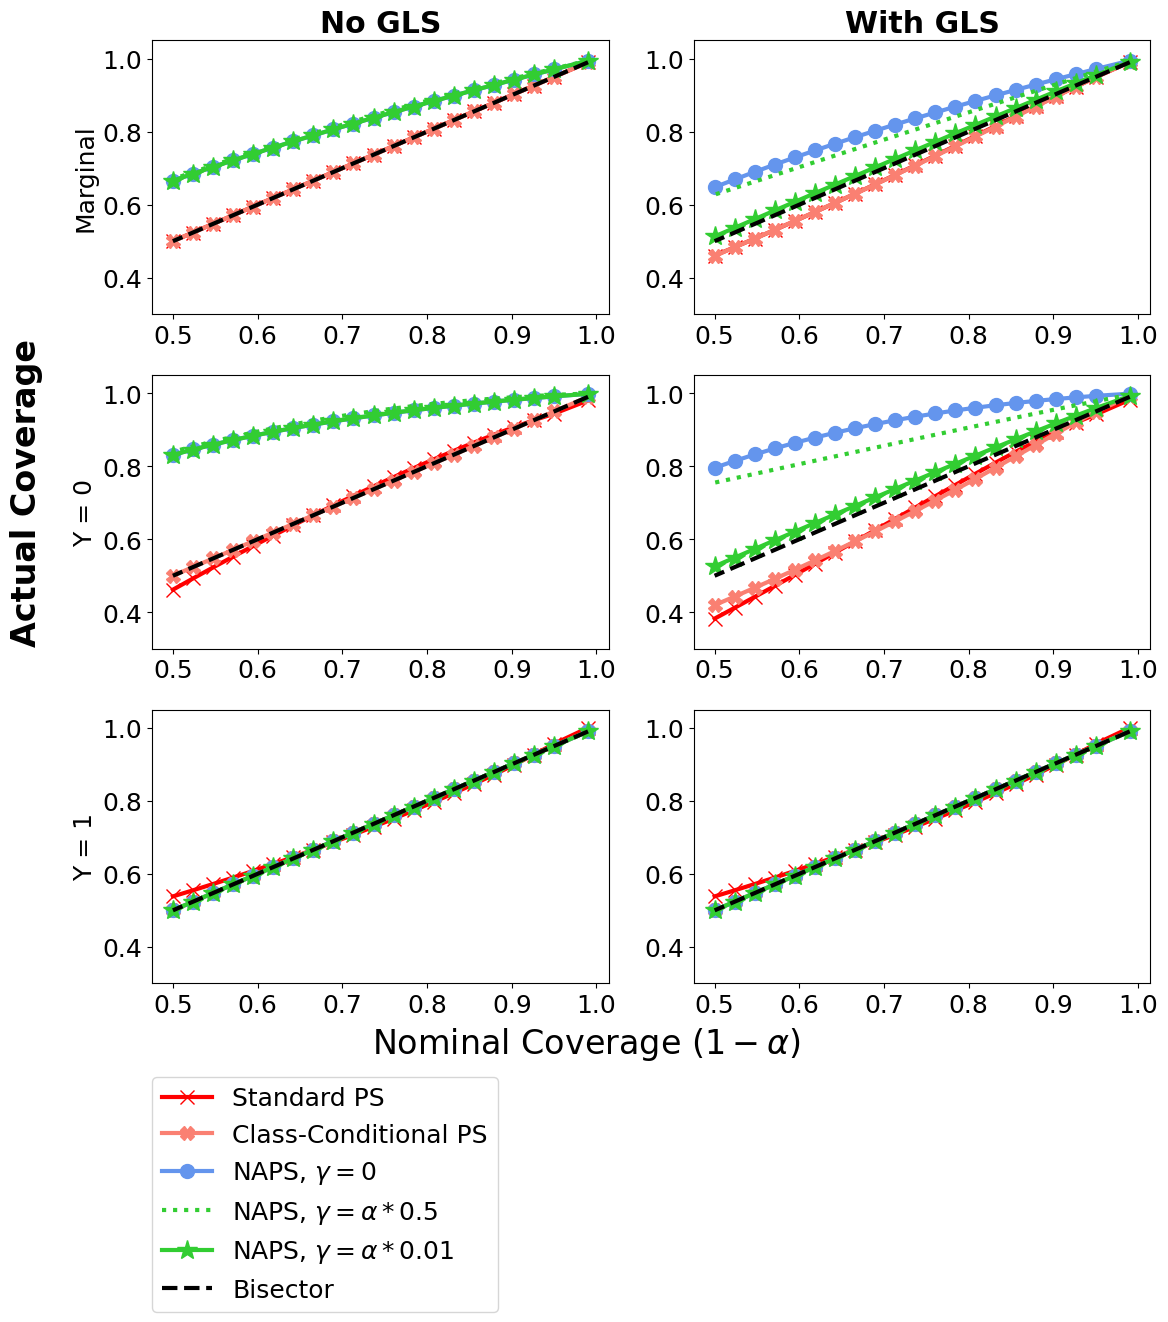

In [607]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

for i, stuff in enumerate(zip(["marg", "bgnull", "signalnull"], ["Marginal", "Y = 0", "Y = 1"])):
    class_con, row_label = stuff
    ax[i][0].plot(1-alphas, results_dict[f"common_oldp_{class_con}_coverage"], label="Standard PS", color="red", marker="x", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"bad_oldp_{class_con}_coverage"], label="Class-Conditional PS", color="salmon", marker="X", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_coverage"], label=r"NAPS, $\gamma=0$", color=zero_naps_col, marker="o", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"calnacs1_oldp_{class_con}_coverage"], label=r"NAPS, $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][0].plot(1-alphas, results_dict[f"calnacs2_oldp_{class_con}_coverage"], label=r"NAPS, $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][0].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black", label="Bisector")
    ax[i][0].set_ylabel(row_label)
    ax[i][0].set_ylim(0.3, 1.05)

    ax[i][1].plot(1-alphas, results_dict[f"common_newp_{class_con}_coverage"], label="Ignores NP", color="red", marker="x", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"bad_newp_{class_con}_coverage"], label="Ignores NP", color="salmon", marker="X", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"cal_newp_{class_con}_coverage"], label="Conservative Cutoff", color=zero_naps_col, marker="o", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"calnacs1_newp_{class_con}_coverage"], label=r"NACS $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][1].plot(1-alphas, results_dict[f"calnacs2_newp_{class_con}_coverage"], label=r"NACS $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][1].plot(1-alphas, 1 - alphas, linestyle="dashed", color="black")
    ax[i][1].set_ylim(0.3, 1.05)


ax[0][0].set_title(f"No GLS", weight="bold")
ax[0][1].set_title(f"With GLS", weight="bold")
ax[2][0].legend(loc=(0, -1.2))
fig.supxlabel("Nominal Coverage " r"($1-\alpha$)", y=0.28, fontsize=axis_label_size)
fig.supylabel("Actual Coverage", fontsize=axis_label_size, y = 0.66, weight="bold")

fig.tight_layout()
fig.savefig("icml_synth_coverage_deep.pdf")


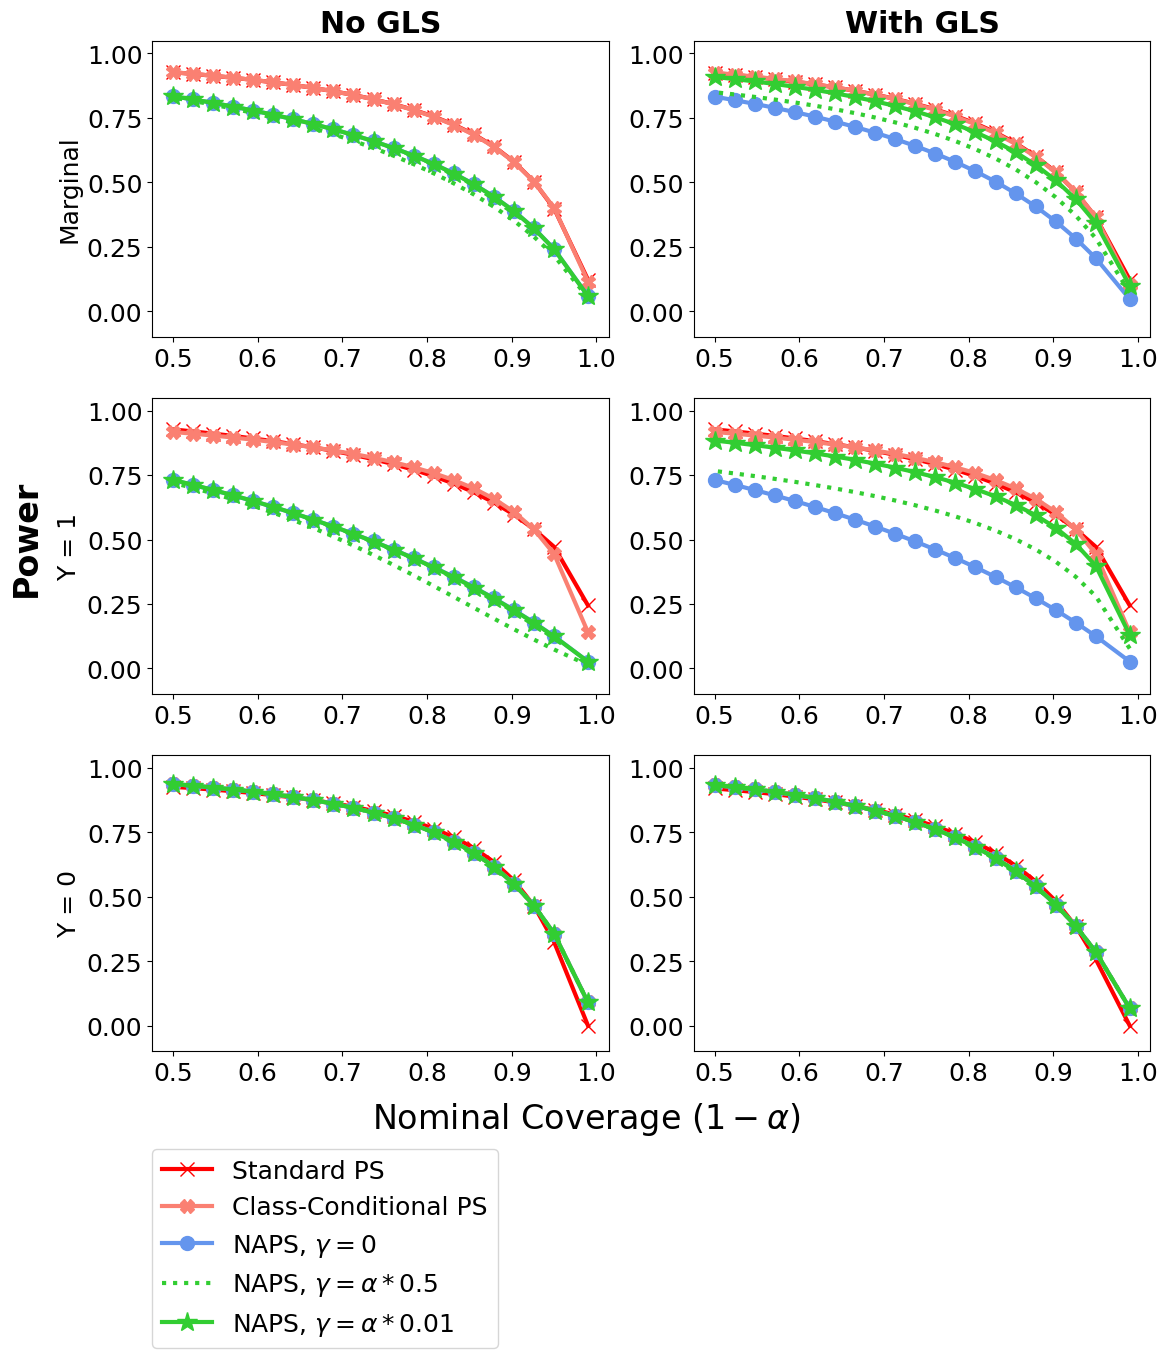

In [608]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

for i, stuff in enumerate(zip(["marg", "bgnull", "signalnull"], ["Marginal", "Y = 1", "Y = 0"])):
    class_con, row_label = stuff
    ax[i][0].plot(1-alphas, results_dict[f"common_oldp_{class_con}_power"], label="Standard PS", color="red", marker="x", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"bad_oldp_{class_con}_power"], label="Class-Conditional PS", color="salmon", marker="X", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_power"], label=r"NAPS, $\gamma=0$", color=zero_naps_col, marker="o", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"calnacs1_oldp_{class_con}_power"], label=r"NAPS, $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][0].plot(1-alphas, results_dict[f"calnacs2_oldp_{class_con}_power"], label=r"NAPS, $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][0].set_ylabel(row_label)
    ax[i][0].set_ylim(-0.1, 1.05)

    ax[i][1].plot(1-alphas, results_dict[f"common_newp_{class_con}_power"], label="Ignores NP", color="red", marker="x", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"bad_newp_{class_con}_power"], label="Ignores NP", color="salmon", marker="X", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"cal_newp_{class_con}_power"], label="Conservative Cutoff", color=zero_naps_col, marker="o", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"calnacs1_newp_{class_con}_power"], label=r"NACS $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][1].plot(1-alphas, results_dict[f"calnacs2_newp_{class_con}_power"], label=r"NACS $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][1].set_ylim(-0.1, 1.05)
    
ax[0][0].set_title(f"No GLS", weight="bold")
ax[0][1].set_title(f"With GLS", weight="bold")
ax[2][0].legend(loc=(0, -1.0))
fig.supxlabel("Nominal Coverage " r"($1-\alpha$)", y=0.23, fontsize=axis_label_size)
fig.supylabel("Power", fontsize=axis_label_size, y=0.63, weight="bold")

fig.tight_layout()
fig.savefig("icml_synth_power_deep.pdf")


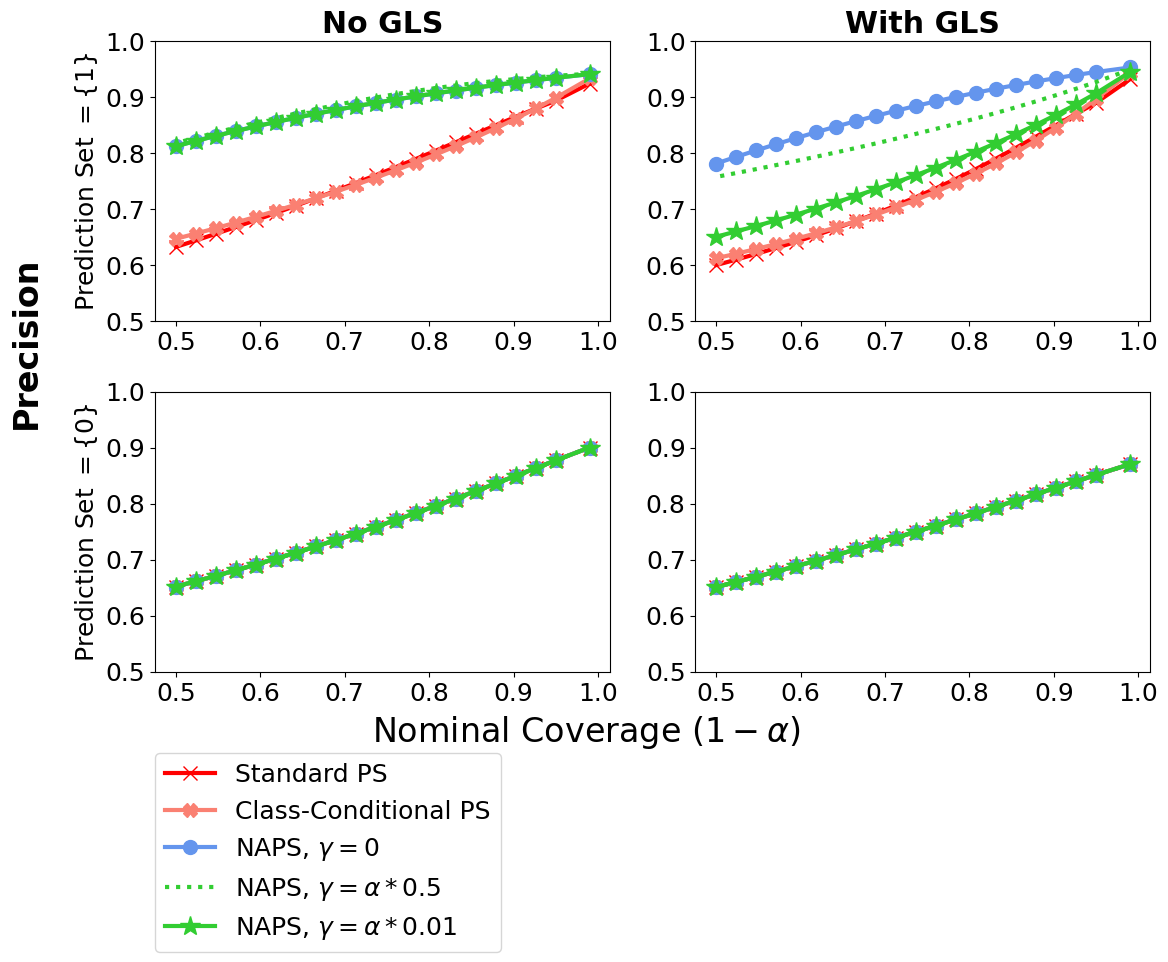

In [609]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, stuff in enumerate(zip(["bgnull", "signalnull"], [r"Prediction Set $ = \{1\}$", r"Prediction Set $ = \{0\}$"])):
    class_con, row_label = stuff
    ax[i][0].plot(1-alphas, results_dict[f"common_oldp_{class_con}_precision"], label="Standard PS", color="red", marker="x", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"bad_oldp_{class_con}_precision"], label="Class-Conditional PS", color="salmon", marker="X", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"cal_oldp_{class_con}_precision"], label=r"NAPS, $\gamma=0$", color=zero_naps_col, marker="o", markersize=10)
    ax[i][0].plot(1-alphas, results_dict[f"calnacs1_oldp_{class_con}_precision"], label=r"NAPS, $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][0].plot(1-alphas, results_dict[f"calnacs2_oldp_{class_con}_precision"], label=r"NAPS, $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][0].set_ylabel(row_label)
    ax[i][0].set_ylim(0.5, 1)

    ax[i][1].plot(1-alphas, results_dict[f"common_newp_{class_con}_precision"], label="Ignores NP", color="red", marker="x", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"bad_newp_{class_con}_precision"], label="Ignores NP", color="salmon", marker="X", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"cal_newp_{class_con}_precision"], label="Conservative Cutoff", color=zero_naps_col, marker="o", markersize=10)
    ax[i][1].plot(1-alphas, results_dict[f"calnacs1_newp_{class_con}_precision"], label=r"NACS $\gamma=\alpha * 0.5$", color=pos_naps_col, linestyle="dotted")
    ax[i][1].plot(1-alphas, results_dict[f"calnacs2_newp_{class_con}_precision"], label=r"NACS $\gamma=\alpha * 0.01$", color=pos_naps_col, marker="*", markersize=15)
    ax[i][1].set_ylim(0.5, 1)
    
ax[0][0].set_title(f"No GLS", weight="bold")
ax[0][1].set_title(f"With GLS", weight="bold")
ax[1][0].legend(loc=(0, -1.0))
fig.supxlabel("Nominal Coverage " r"($1-\alpha$)", y=0.36, fontsize=axis_label_size)
fig.supylabel("Precision", fontsize=axis_label_size, y = 0.7, weight="bold")

fig.tight_layout()
fig.savefig("icml_synth_precision_deep.pdf")

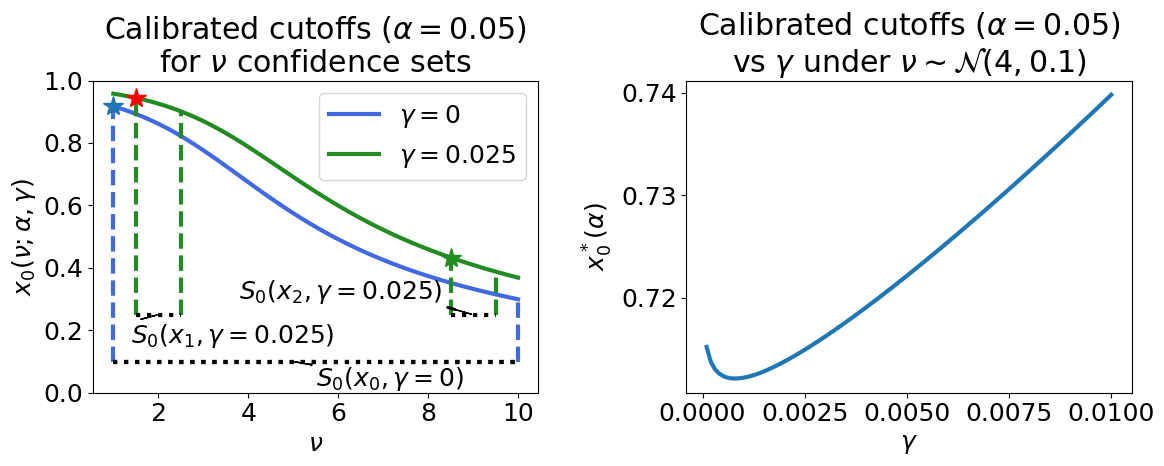

In [610]:
plot_nu = np.linspace(1, 10, 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
target_alpha = 0.05

def cutoff_func(alpha, nu):
    return scipy.optimize.root_scalar( 
        lambda x: fpr(x, nu) - alpha,
        x0=0.5, 
        bracket=[0, 1],
        method="brentq"
    ).root

betas = [0.05, 0.025]
colors = ["royalblue", "forestgreen"]
for beta, color in zip(betas, colors):
    ax[0].plot(plot_nu, [cutoff_func(beta, nu) for nu in plot_nu], label= r"$\gamma=$" + (f"{target_alpha - beta:0.3f}" if beta != 0.05 else "0" ), color=color)
    
nu_lb1 = 1.5
nu_ub1 = 2.5
nu_lb2 = 8.5
nu_ub2 = 9.5
    
ax[0].legend()
ax[0].vlines(1, 0.1, cutoff_func(target_alpha, 1), linestyle="dashed", color=colors[0])
ax[0].vlines(10, 0.1, cutoff_func(target_alpha, 10), linestyle="dashed", color=colors[0])
ax[0].vlines(nu_lb1, 0.25, cutoff_func(betas[1], nu_lb1), linestyle="dashed", color=colors[1])
ax[0].vlines(nu_ub1, 0.25, cutoff_func(betas[1], nu_ub1), linestyle="dashed", color=colors[1])
ax[0].hlines(0.25, nu_lb1, nu_ub1, color="black", linestyle="dotted")
ax[0].vlines(nu_lb2, 0.25, cutoff_func(betas[1], nu_lb2), linestyle="dashed", color=colors[1])
ax[0].vlines(nu_ub2, 0.25, cutoff_func(betas[1], nu_ub2), linestyle="dashed", color=colors[1])
ax[0].hlines(0.25, nu_lb2, nu_ub2, color="black", linestyle="dotted")

ax[0].hlines(0.1, 1, 10, color="black", linestyle="dotted")
ax[0].annotate(r"$S_0(x_0, \gamma = 0)$", (5, 0.1), (5.5, 0.02), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=0))
ax[0].hlines(0.1, 1, 10, color="black", linestyle="dotted")
ax[0].annotate(r"$S_0(x_1, \gamma = 0.025)$", (2, 0.25), (1.4, 0.16), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=0))
ax[0].annotate(r"$S_0(x_2, \gamma = 0.025)$", (9, 0.25), (3.8, 0.3), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=0))

ax[0].plot(1, cutoff_func(target_alpha, 1), marker="*", color="C0", markersize=15 )
ax[0].plot(nu_lb1, cutoff_func(betas[1], nu_lb1), marker="*", color="red", markersize=15)
ax[0].plot(nu_lb2, cutoff_func(betas[1], nu_lb2), marker="*", color="forestgreen", markersize=15)

ax[0].set_title(r"Calibrated cutoffs $(\alpha = 0.05)$" "\n" r"for $\nu$ confidence sets")
ax[0].set_ylabel(r"$x_0(\nu ; \alpha, \gamma)$")
ax[0].set_xlabel(r"$\nu$")
ax[0].set_ylim(0, 1)

gamma_set = np.linspace(0.0001, 0.01, 100)
ax[1].plot(gamma_set, [cutoff_func(target_alpha - gamma, normal_prior_unconstrained.ppf(gamma/2 * normal_prior_scaling)) for gamma in gamma_set])
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_ylabel(r"$x_0^*(\alpha)$")
ax[1].set_title("Calibrated cutoffs " r"$(\alpha = 0.05)$" "\n" r"vs $ \gamma$ "  r"under $\nu \sim \mathcal{N}(4, 0.1)$")

fig.tight_layout()
fig.savefig("icml_synth_NAPS_nucs.pdf")